In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp
import scipy.stats as stats

import arviz as az

# Generate synthetic data

Define the Lotka-Volterra model:

In [2]:
def lotka_volterra(t, u, theta):
    u1, u2 = u
    return [
        theta[0] * u1 - theta[1] * u1 * u2,
        theta[3] * u1 * u2 - theta[2] * u2,
    ]

Solve the coupled ODEs:

In [3]:
t_n = 2500  # number of time data points
t_span = [0, 25]  # the time span over which to integrate the system
theta = [0.67, 1.33, 1, 1]  # parameters of the model
d = len(theta)  # dimension of the parameter space
u_init = [1, 1]  # initial values

In [4]:
sol = solve_ivp(lotka_volterra, t_span, u_init, args=(theta,), dense_output=True)

In [5]:
t = np.linspace(t_span[0], t_span[1], t_n)
u = sol.sol(t).T

Add Gaussian noise:

In [6]:
rng = np.random.default_rng(12345)

In [7]:
means = [0, 0]
C = np.diag([0.2 ** 2, 0.2 ** 2])

In [8]:
eps = stats.multivariate_normal.rvs(mean=means, cov=C, size=len(t), random_state=rng)
y = u + eps

Plot the resulting values:

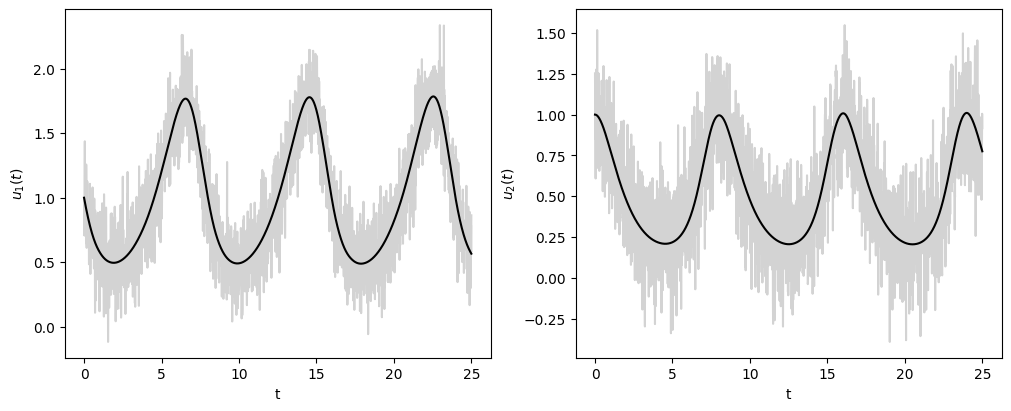

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
for i in range(2):
    axs[i].plot(t, y[:, i], color='lightgray');
    axs[i].plot(t, u[:, i], color='black');
    axs[i].set_xlabel('t');
    axs[i].set_ylabel(f'$u_{i + 1}(t)$');

# Sample using random-walk Metropolis-Hastings algorithm

Implement random-walk Metropolis-Hastings algorithm by hand:

In [10]:
def sample_chain(theta_sampler, theta_init, n_draws):
    """Sample a single chain of given length using the starting the values provided"""
    # set the starting values
    theta = np.array(theta_init, copy=True)

    # create an array for the trace
    trace = np.empty((n_draws + 1, d))

    # store the initial values
    trace[0, :] = theta

    # sample variables
    for i in range(n_draws):
        # sample new theta
        theta = theta_sampler(theta)

        # record the value in the trace
        trace[i + 1, :] = theta

    return trace

In [22]:
def to_arviz(chains, var_names):
    """Convert output to arviz format"""
    assert len(chains) > 0
    return az.from_dict({var_name: np.stack([chain[:, i] for chain in chains]) for i, var_name in enumerate(var_names)})

In [12]:
def metropolis_random_walk_step(log_target_density, proposal_sampler):
    """Perform a Metropolis-Hastings random walk step"""
    def sampler(theta):
        # propose a new value
        theta_proposed = proposal_sampler(theta)

        # decide whether to accept the new value
        log_acceptance_probability = np.minimum(0, log_target_density(theta_proposed) - log_target_density(theta))
        u = rng.random()
        if u == 0 or np.log(u) < log_acceptance_probability:
            return theta_proposed
        else:
            return theta

    return sampler

In [13]:
def log_target_density(theta):
    sol = solve_ivp(lotka_volterra, t_span, u_init, args=(np.exp(theta),), dense_output=True)
    u = sol.sol(t).T
    log_likelihood = np.sum(stats.multivariate_normal.logpdf(y - u, mean=means, cov=C))
    log_prior = np.sum(stats.norm.logpdf(theta))
    return log_likelihood + log_prior

In [14]:
def rw_proposal_sampler(step_size):
    G = step_size * np.identity(d)
    def sampler(theta):
        xi = stats.norm.rvs(size=d)
        return theta + G @ xi
    return sampler

In [30]:
n_draws = 50_000

In [31]:
step_size = 0.01  # TODO use Roberts and Rosenthal (2001) to select the step size

In [32]:
%%time
theta_sampler = metropolis_random_walk_step(log_target_density, rw_proposal_sampler(step_size))
chain = sample_chain(theta_sampler, np.log([0.55, 1, 0.8, 0.8]), n_draws)

CPU times: user 10min 46s, sys: 316 ms, total: 10min 46s
Wall time: 10min 49s


Reproduce the first column in Figure S17 from the Supplementary Material:

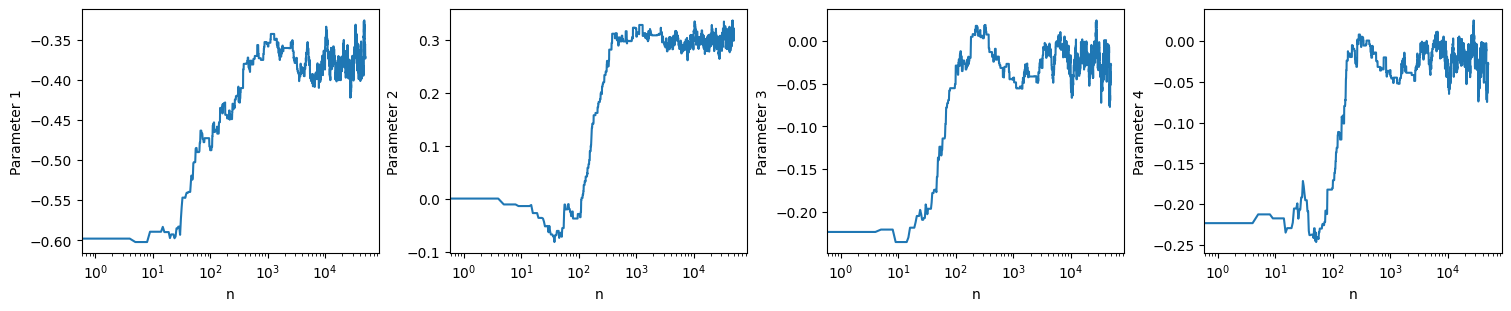

In [45]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3), constrained_layout=True)
for i in range(d):
    axs[i].plot(chain[:, i]);
    axs[i].set_xscale('log');
    axs[i].set_xlabel('n');
    axs[i].set_ylabel(f'Parameter {i + 1}');